# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. <br>
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. <br>
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». 

## Импортируем датасет и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Поиск явных дубликатов**

In [4]:
data.duplicated().sum() 

0

Явные дубликаты отсуствуют

**Описание данных**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Подготовка данных

### Приводим название стобцов к нижнему регистру

In [5]:
data.columns = map(str.lower, data.columns)

### Преобразуем данные к нужному типу

In [6]:
display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В столбце user_score имееться аббревиатура "TBD". <br>
TBD [To Be Determined] - дословный перевод "подлежит определению", данные проекты малопопулярны из-за этого рейтинг этих игр у игроков не известен, слишком малое количество оценок от игроков.<br>
Стоит заменить TBD на Nan 

In [7]:
print(data['user_score'].unique())
#заменим TBD на Nan
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype('float')

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


In [8]:
data['user_score'] = pd.to_numeric(data.user_score, errors='coerce')
#data['year_of_release'] = pd.to_datetime(data.year_of_release, format='%Y')
#data['year_of_release'] = data['year_of_release'].dt.year

<br> **Изменения внесенные в типы данных.** <br>
name - без изменений <br>
platform - без изменений<br>
year_of_release - без изменений<br>
genre - без изменений<br>
na_sales, eu_sales, jp_sales, other_sales- без изменений<br>
critic_score - без изменений<br>
user_score - переводим в формат float<br>
rating - переводим в формат категории<br>

### Обработка пропусков

In [9]:
data.isnull().sum() #Определяем основные столбцы с пропусками

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Заглушки удалены, данные остануться без изменений.

In [10]:
#Заменим пропущенные значения на "undefiend"
data["rating"] = data['rating'].fillna("undefined")

В сонове своей пропуски сосредоточены в "рейтинговой" части, моду на рейтинги ввели относительно недавно. Так же возможно наличие в датасете малоизвестных проектов - соотведственно у них может и не быть рейтинга. <br>
Так же не стоит отбрасывать вариант - возникновение пропусков из-за неудачной выгрузки данных. <br>
Пока что оставим все без изменений.

### Сумарные продажи

Введенм столбец total_sales в котором просуммируем стобцы с продажами в отдельных регионах.

In [11]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [12]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16715 non-null  object 
 11  total_sales      16715 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'wwe Smackdown vs. Raw 2006' '¡Shin Chan Flipa en colores!' nan]
name : кол-во NaN 2 , про

## Исследовательский анализ данных

<AxesSubplot:title={'center':'games per year'}, ylabel='Frequency'>

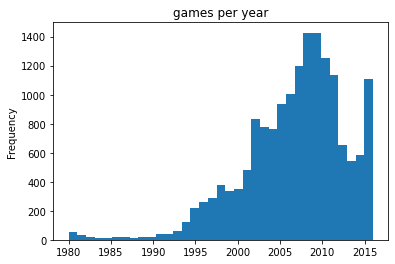

In [13]:
data['year_of_release'].plot(kind='hist',bins=35,title='games per year')

Игры начали выходить с 1980, но наибольшее количество игр начали выпускать с середины 90х, с эпохи расвета первых консолей. <br>
Стоит рассматривать данные с 1995 года.


platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       30.77
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

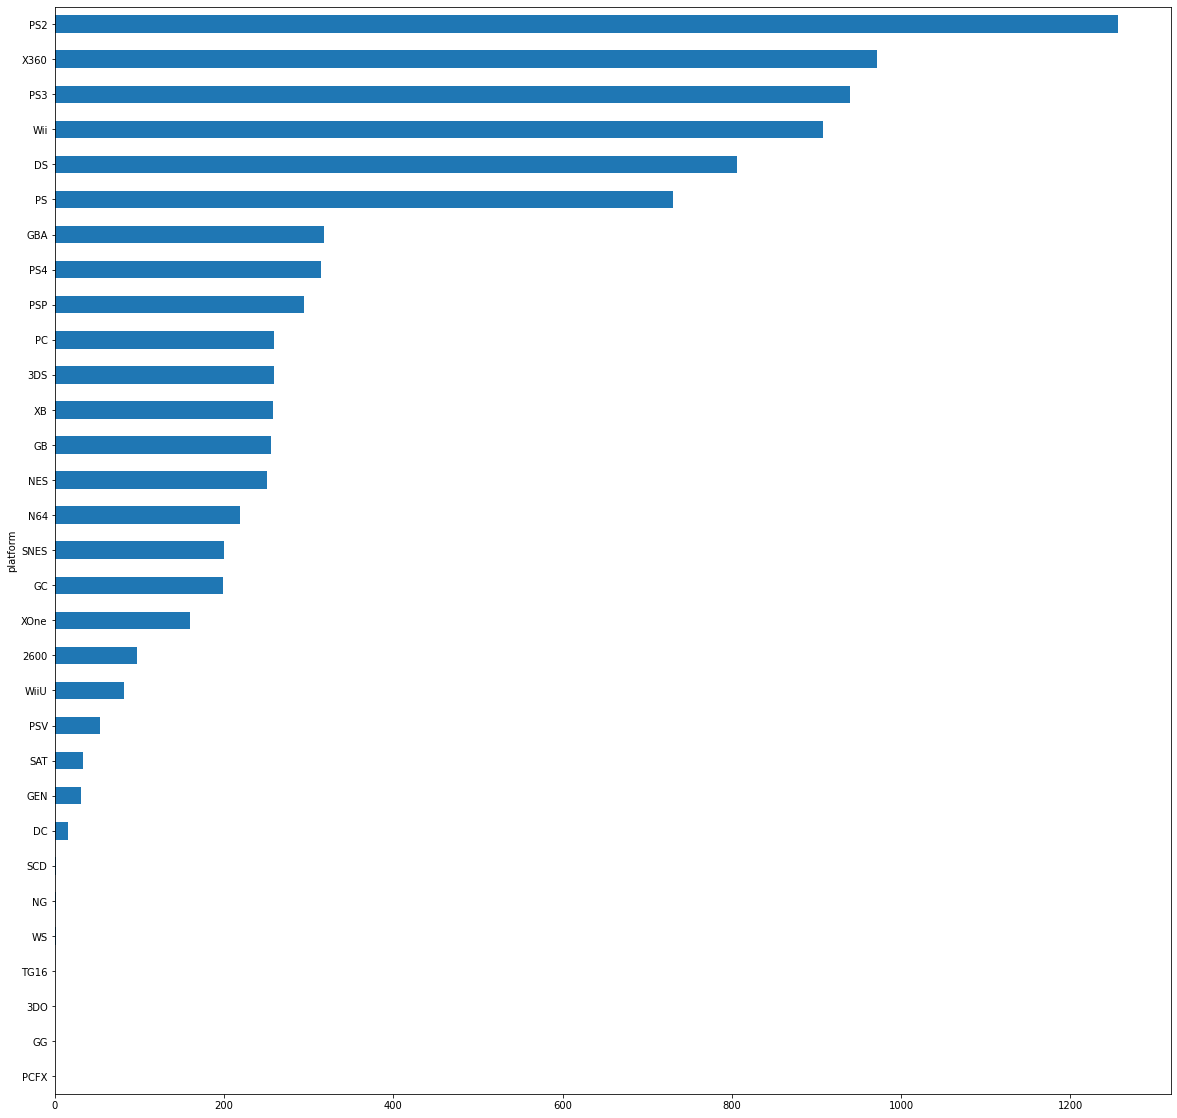

In [14]:
data.groupby(by='platform').sum()['total_sales'].sort_values().plot(kind='barh',figsize=(20,20));
data.groupby(by='platform').sum()['total_sales'].sort_values(ascending=False)

Для анализа возьмем топ-5 по суммарным продажам платформ.

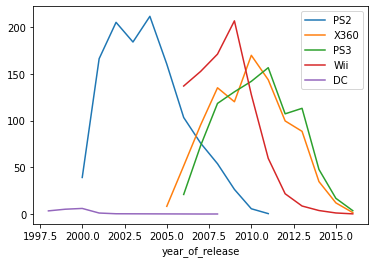

In [15]:
data[data['platform']=='PS2'].groupby(by='year_of_release')['total_sales'].sum().plot()
data[data['platform']=='X360'].groupby(by='year_of_release')['total_sales'].sum().plot()
data[data['platform']=='PS3'].groupby(by='year_of_release')['total_sales'].sum().plot()
data[data['platform']=='Wii'].groupby(by='year_of_release')['total_sales'].sum().plot()
data[data['platform']=='DC'].groupby(by='year_of_release')['total_sales'].sum().plot()
plt.legend(['PS2','X360',"PS3","Wii",'DC'])
plt.rcParams["figure.figsize"] = [10, 10]

Характерный срок эксплуатации платформы(консоли) 10 лет - после она устаревает и выпуск игр на ней прекращаеться.

Если в среднем платформа устаревает через 10 лет, то для прогноза продаж на 2017 год необходимо взять 3 последних года, на платформы Х360 и PS3 снижаться темпы производства игр, следовательно уже производяться новые платформы и контент для них.

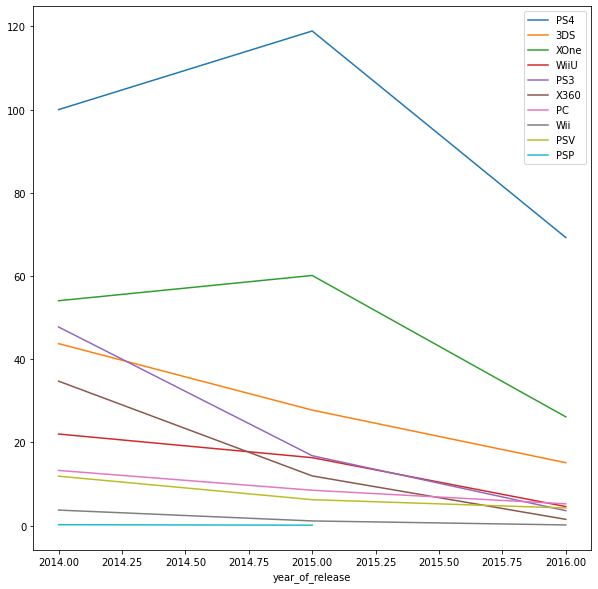

In [16]:
data_after_2013 = data[data['year_of_release'] > 2013]
legends = []
for i in data_after_2013['platform'].unique():
    data_after_2013[data_after_2013['platform']==i].groupby(by='year_of_release')['total_sales'].sum().plot()
    legends.append(i)

plt.legend(legends)
plt.rcParams["figure.figsize"] = [10, 10]

Обьем продаж падает, скорее всего это связано с анонсами новых консолей или застоем на игровом рынке. <br>
По итогу, на конец 2016 года по продажам лидируют: <br>
- PS4 <br>
- XOne <br>
- 3DS <br>

In [17]:
data_after_2013.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

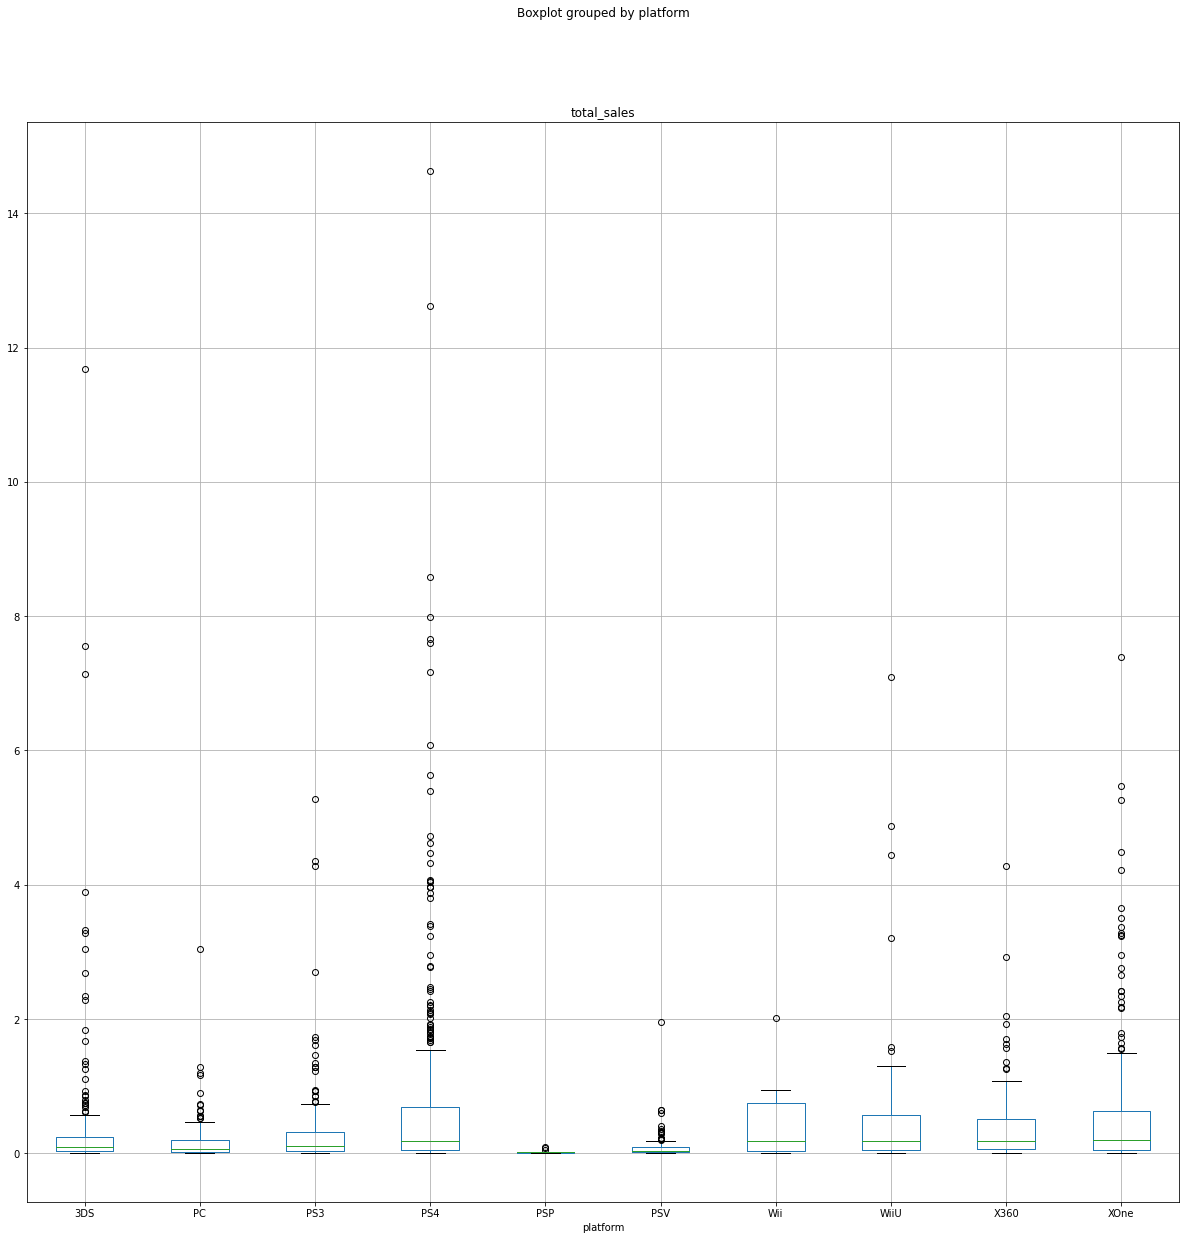

In [18]:
data_after_2013.boxplot(column='total_sales',by='platform',figsize=(20,20))

На графике выше не видны медианы и 75% квантили, дадим отдельную диаграмму на которой они видны более четко.

(0.0, 2.0)

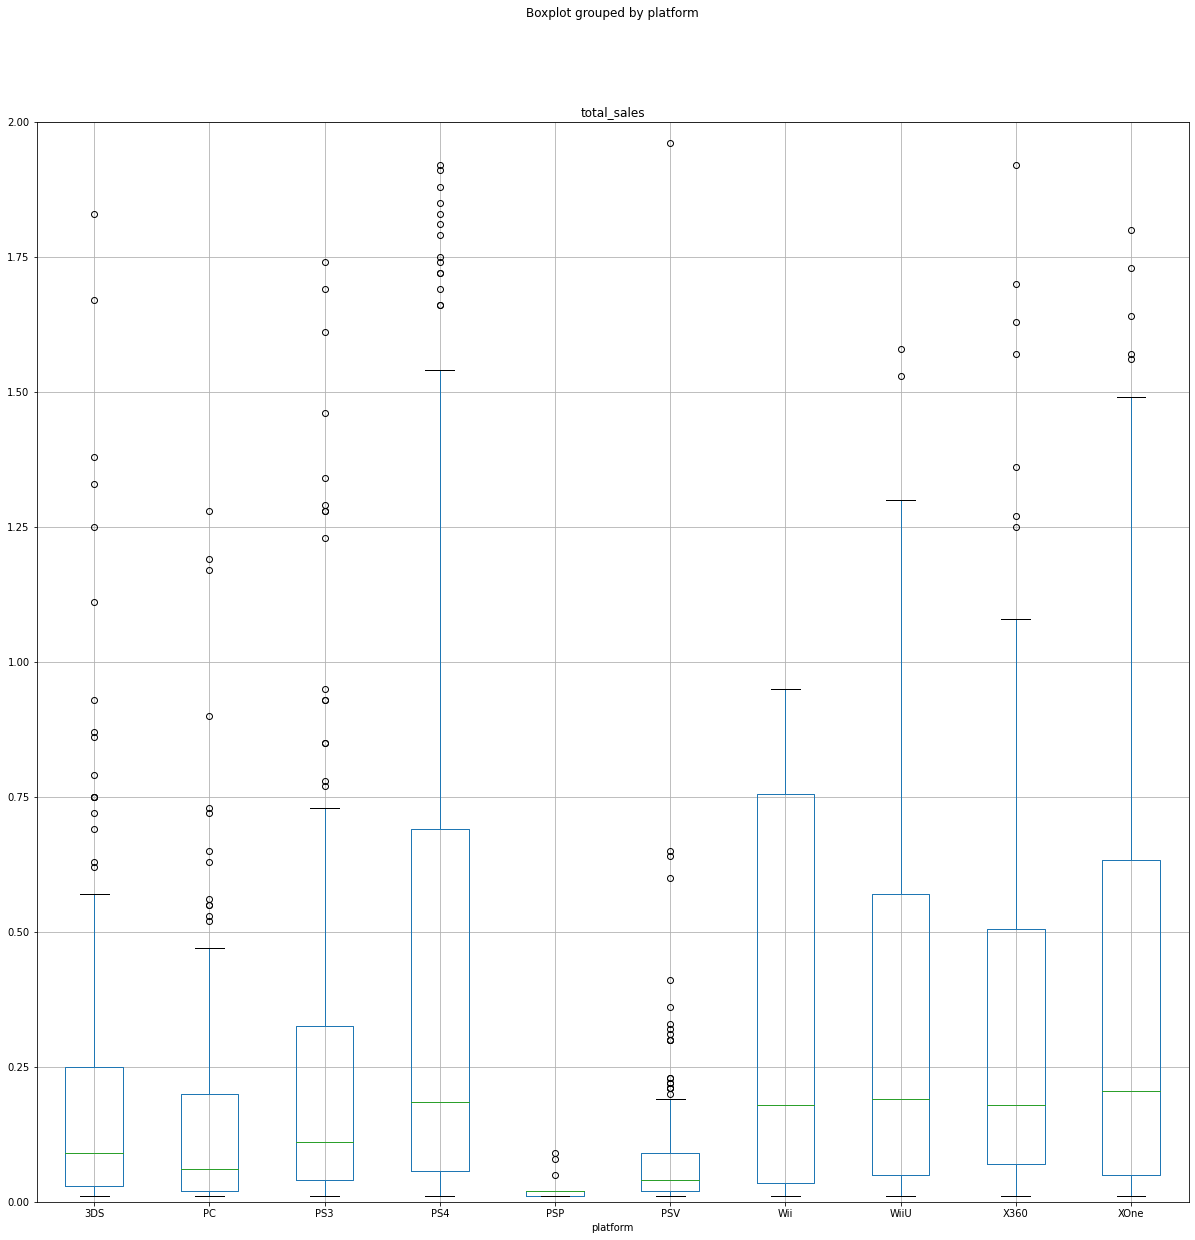

In [19]:
data_after_2013.boxplot(column='total_sales',by='platform',figsize=(20,20))
plt.ylim(0,2)

**Вывод**
- Наибольшие медианные продажи у платформ XOne, WiiU и PS4.
- Максимальные продажи приходяться на PS4 и WiiU.
- Низкие продажи на PC обуславливаються приспособленностью консолей к играм, PC все же универсальный инструмент,а не приставка.
- На всех платформах имеються выбросы, возможно это игры поставляемые в комплекте к консолям или бесплатные раздачи.

Для анализа продаж внутри одной платформы возьмем PS4.

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

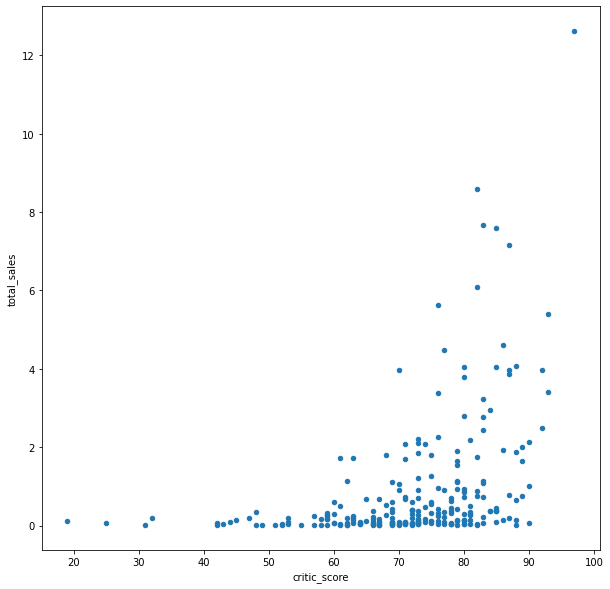

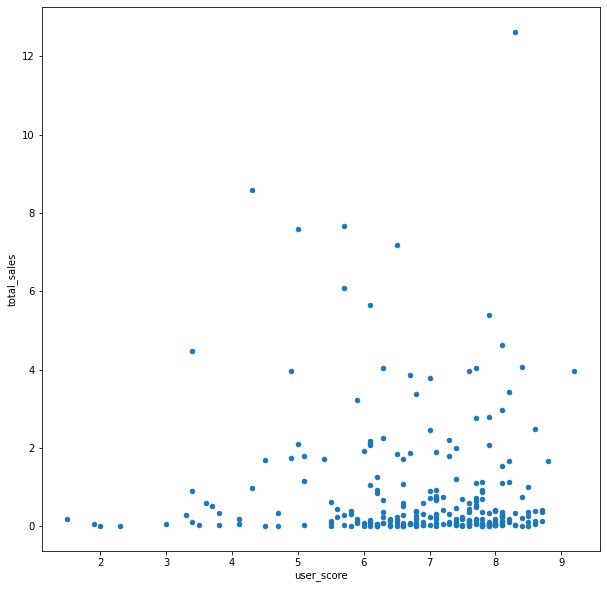

In [20]:
data_after_2013[data_after_2013['platform']=='PS4'].plot.scatter(x = 'critic_score',y= 'total_sales')
data_after_2013[data_after_2013['platform']=='PS4'].plot.scatter(x = 'user_score',y= 'total_sales')

In [21]:
print("Матрица корреляций")
data_after_2013[data_after_2013.platform == "PS4"][['total_sales', 'critic_score', 'user_score']].corr()

Матрица корреляций


,total_sales,critic_score,user_score
total_sales,1.000000,0.402661,-0.040132
critic_score,0.402661,1.000000,0.546434
user_score,-0.040132,0.546434,1.000000


**Вывод** <br>
Кореляция между *рейтингом критиков и продажами на PS4* прослеживаеться - чем выше рейтинг, тем выше продажи. <br>
Кореляция же между *рейтингом игроков и продажами на PS4* не прослеживаеться.<br>

In [22]:
platfoms = ['PS4','3DS','XOne','WiiU','PS3']
for i in  platfoms:
    print(platfoms.index(i))

0
1
2
3
4


Матрица кореляций для PS4
              total_sales  critic_score  user_score
total_sales      1.000000      0.402661   -0.040132
critic_score     0.402661      1.000000    0.546434
user_score      -0.040132      0.546434    1.000000


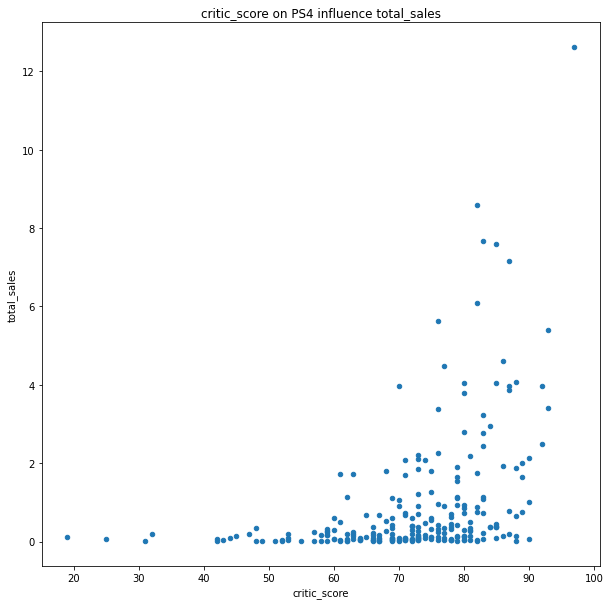

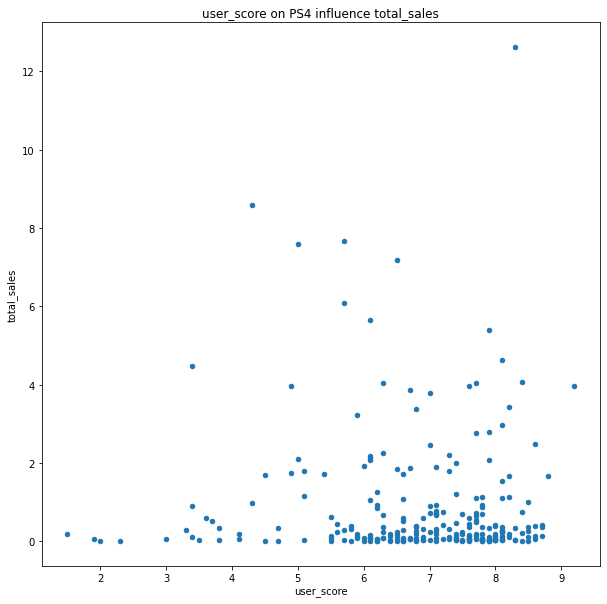

Матрица кореляций для 3DS
              total_sales  critic_score  user_score
total_sales      1.000000      0.314117    0.215193
critic_score     0.314117      1.000000    0.862485
user_score       0.215193      0.862485    1.000000


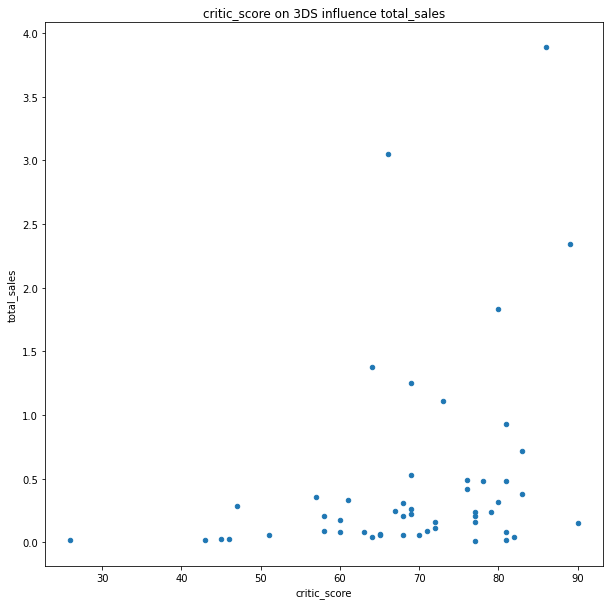

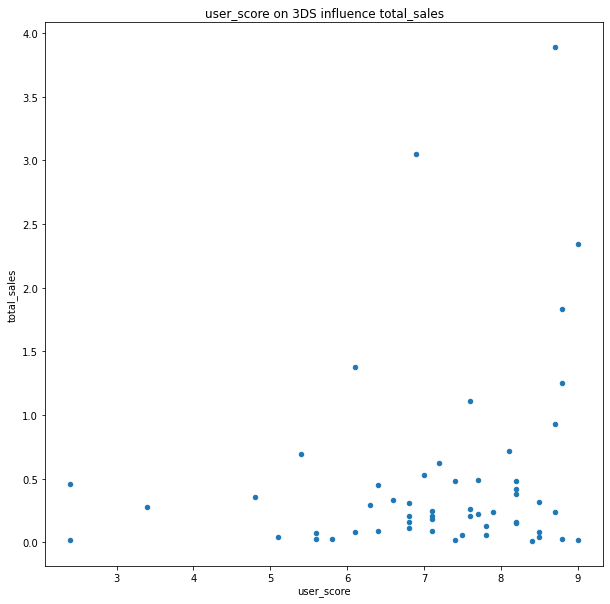

Матрица кореляций для XOne
              total_sales  critic_score  user_score
total_sales      1.000000      0.428677   -0.070384
critic_score     0.428677      1.000000    0.440977
user_score      -0.070384      0.440977    1.000000


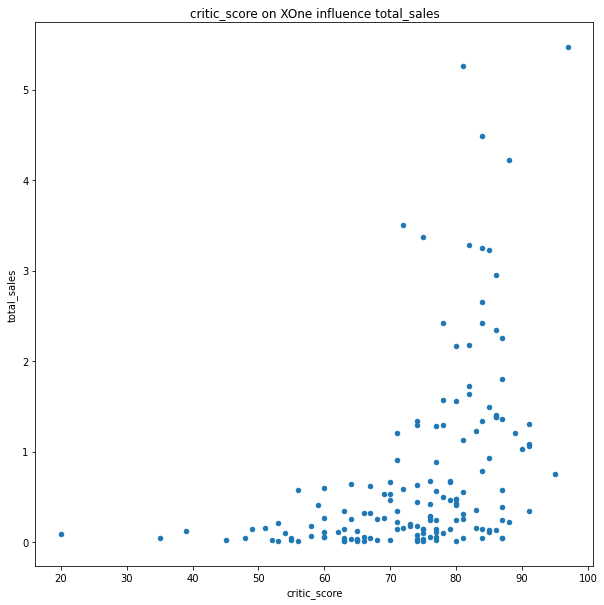

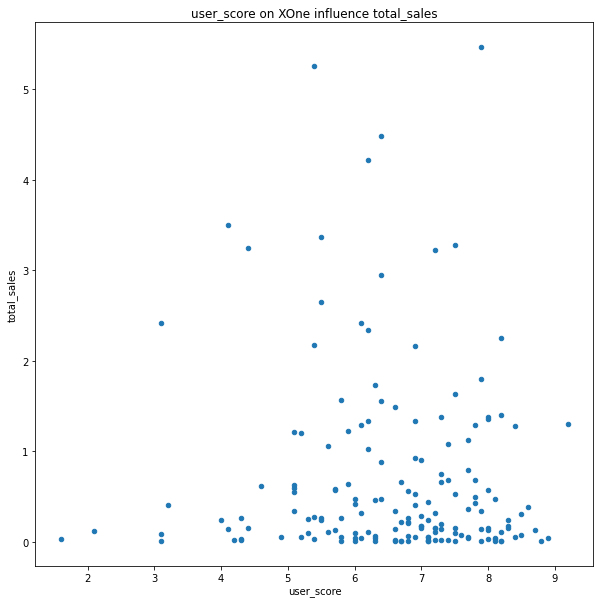

Матрица кореляций для WiiU
              total_sales  critic_score  user_score
total_sales      1.000000      0.370201    0.407926
critic_score     0.370201      1.000000    0.763536
user_score       0.407926      0.763536    1.000000


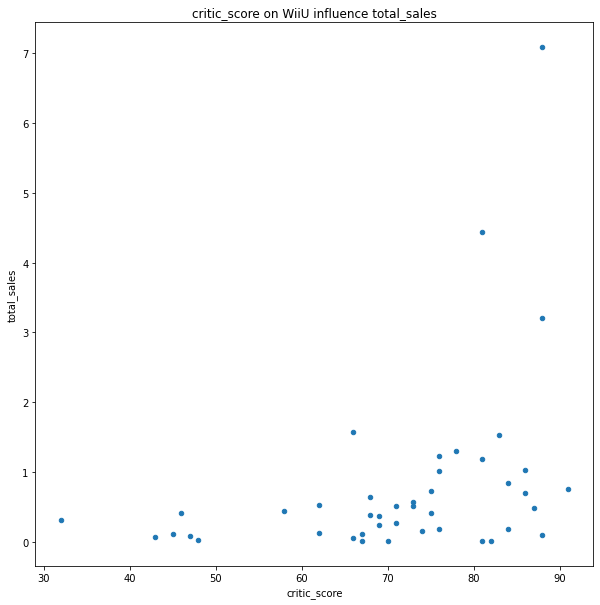

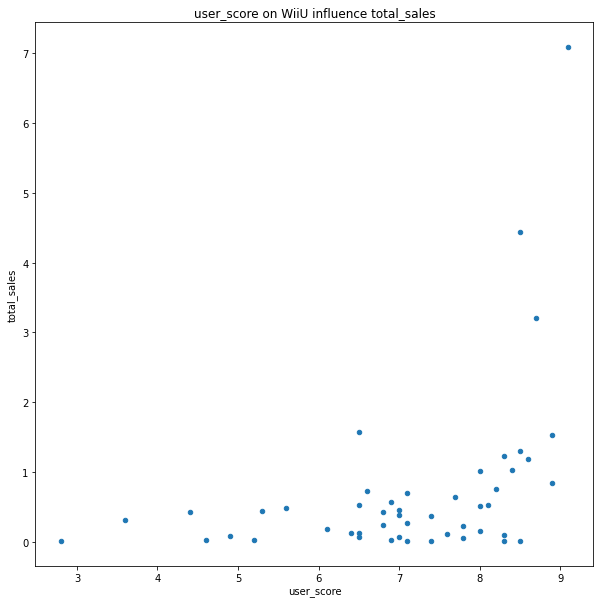

Матрица кореляций для PS3
              total_sales  critic_score  user_score
total_sales      1.000000      0.446575   -0.166761
critic_score     0.446575      1.000000    0.693445
user_score      -0.166761      0.693445    1.000000


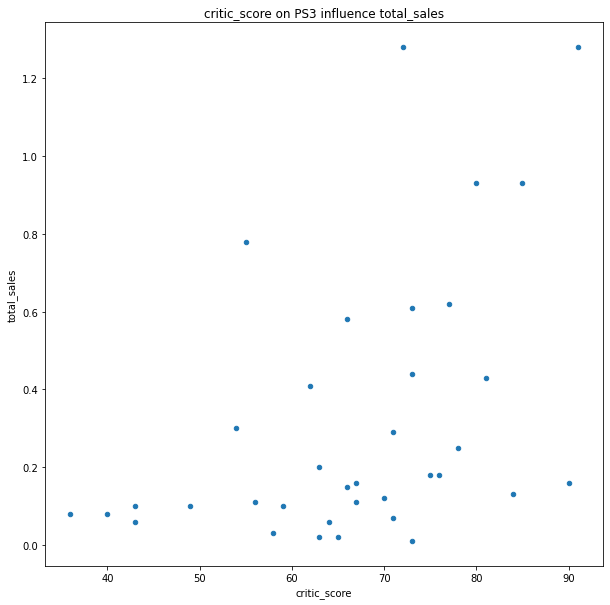

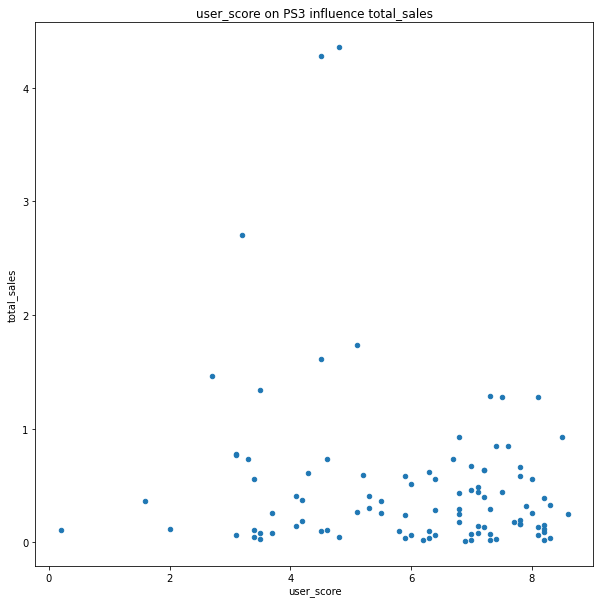

In [23]:
platfoms = ['PS4','3DS','XOne','WiiU','PS3']
for i in  platfoms:
    print('Матрица кореляций для',i)
    print(data_after_2013[data_after_2013.platform == i][['total_sales', 'critic_score', 'user_score']].corr())
    #plt.subplot(platfoms.index(i)+1,2,1)
    data_after_2013[data_after_2013['platform']==i].plot(kind='scatter',x = 'critic_score',y= 'total_sales')
    plt.title('critic_score on'+' '+i+' '+'influence total_sales')
    #plt.subplot(platfoms.index(i)+1,2,2)
    data_after_2013[data_after_2013['platform']==i].plot(kind='scatter',x = 'user_score',y= 'total_sales')
    plt.title('user_score on'+' '+i+' '+'influence total_sales')
    plt.show()

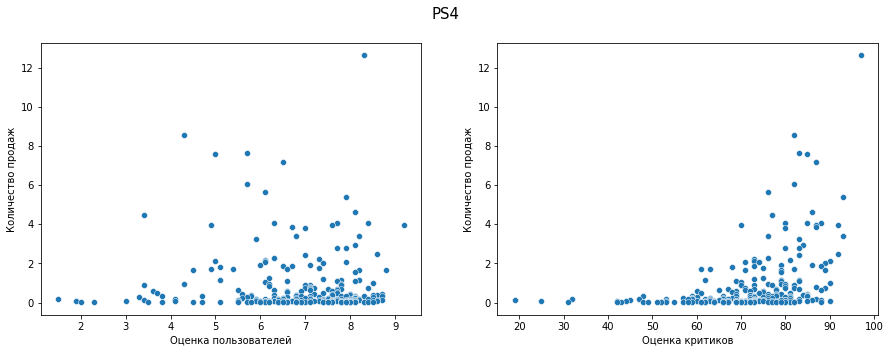

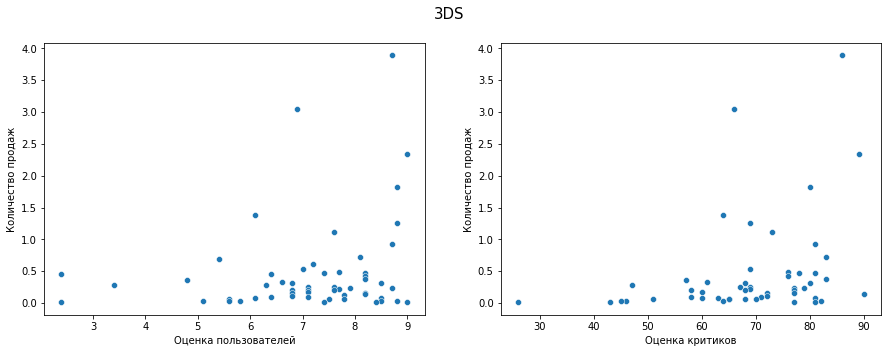

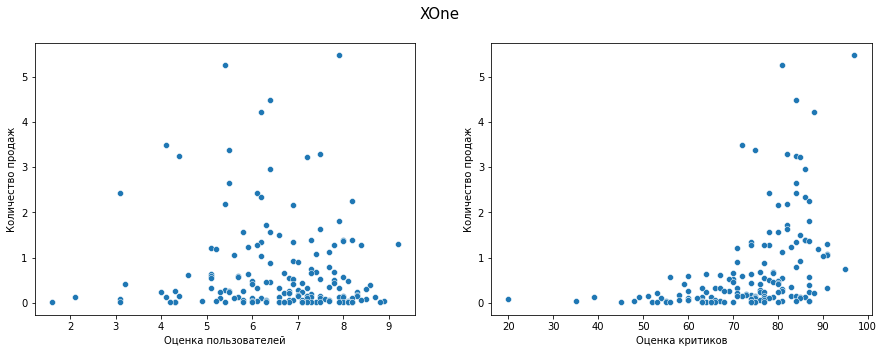

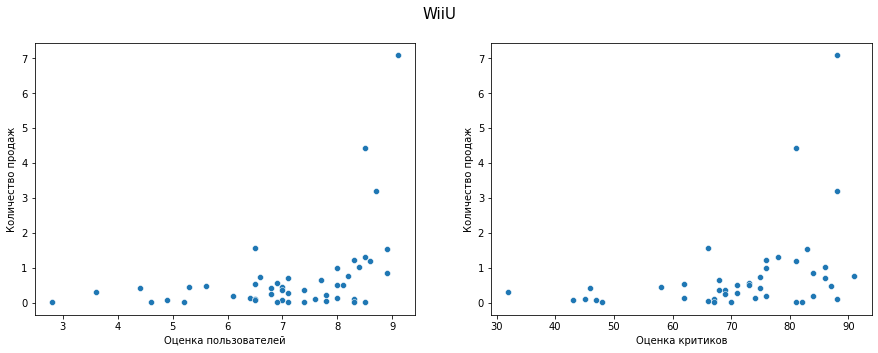

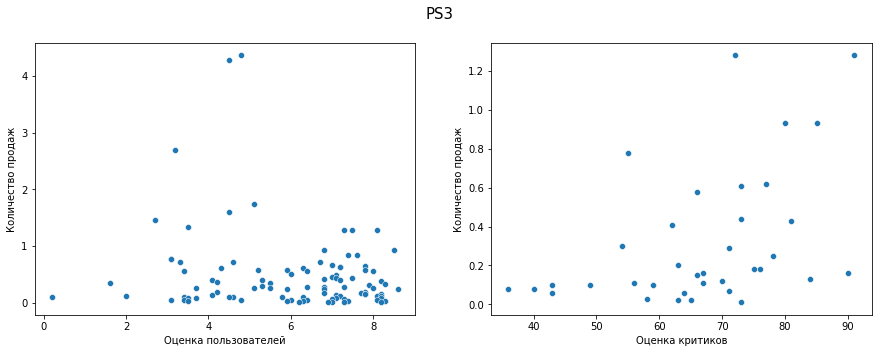

In [42]:
# Комментарий ревьюера 3
df = data_after_2013.copy()
def o_mazurenko(name_of_platform):
    platform = df[df['platform']==name_of_platform]
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=platform, ax=ax[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=platform, ax=ax[1])
    fig.suptitle(name_of_platform, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()

for platform in ['PS4','3DS','XOne','WiiU','PS3']:
    o_mazurenko(platform)

**Вывод** <br>
Для платформ PS3 и XOne ситуация схожая с PS4 - кореляция между user_score и total_sales отсудствует, а critic_score и total_sale присудствует. <br>
С платформами WiiU и 3DS ситуация обстоит иначе - critic_score и user_score коррелируют с total_sales

(0.0, 2.0)

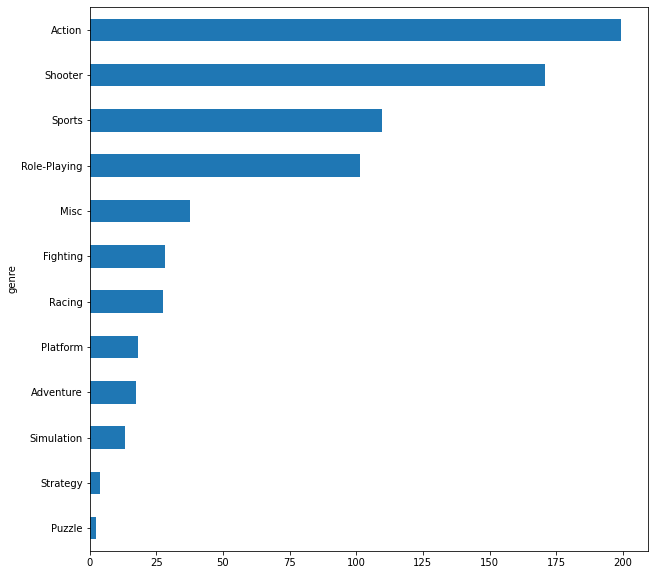

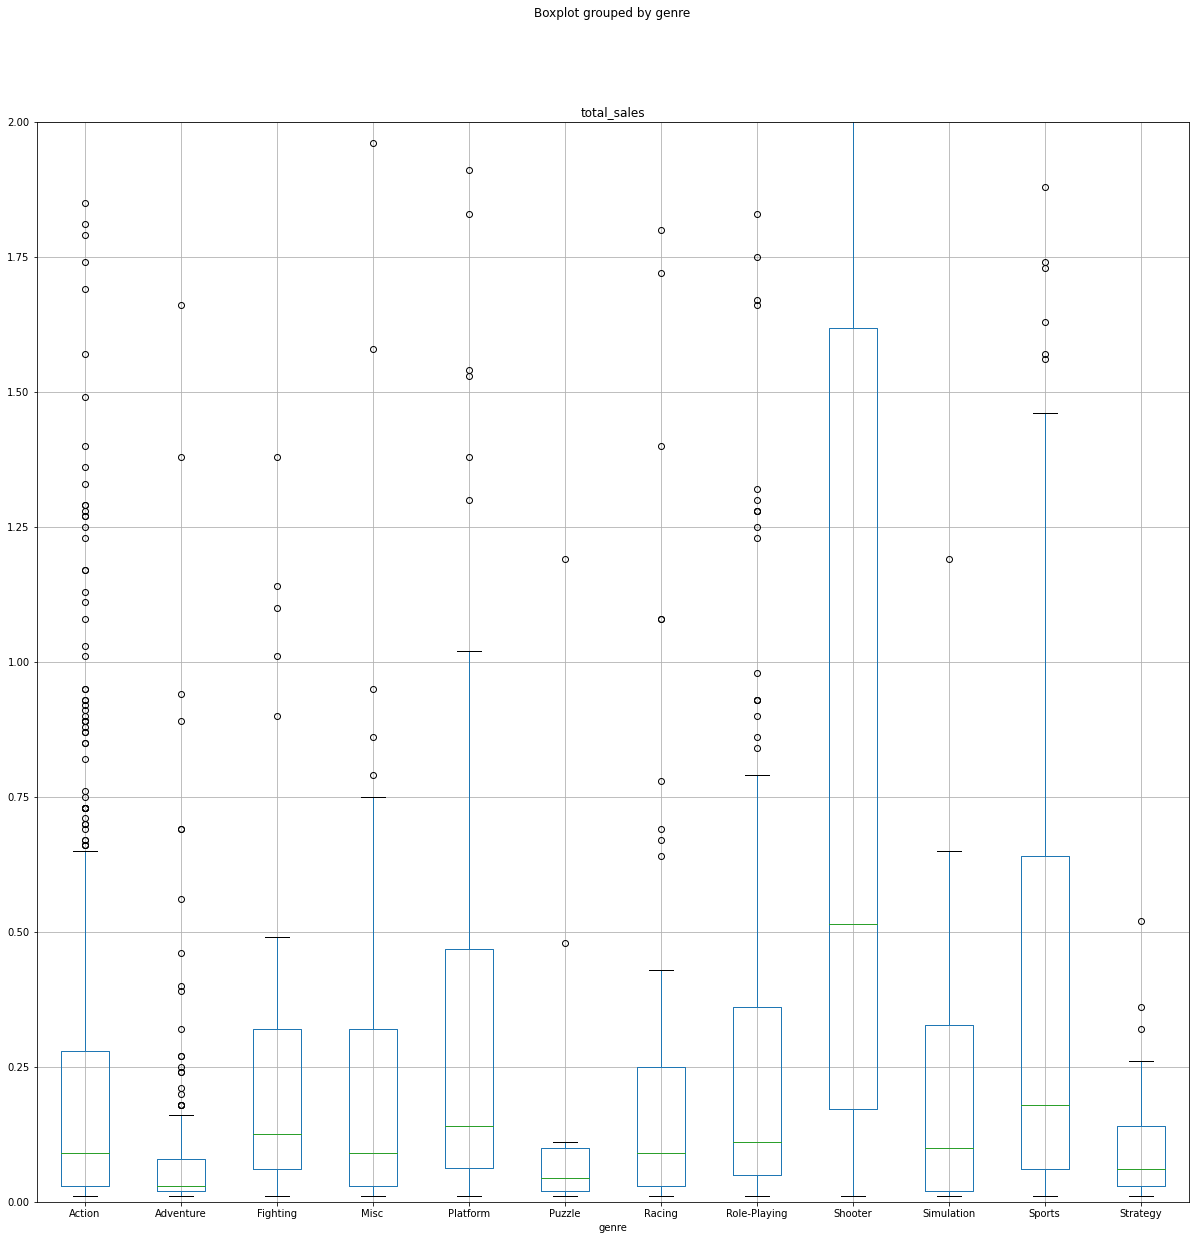

In [24]:
data_after_2013.groupby('genre')['total_sales'].sum().sort_values().plot(kind='barh')
data_after_2013.boxplot(column='total_sales',by='genre',figsize=(20,20))
plt.ylim(0,2)

In [25]:
data_after_2013.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,619.0,0.322068,0.798181,0.01,0.0300,0.090,0.2800,12.62
Adventure,185.0,0.094865,0.203147,0.01,0.0200,0.030,0.0800,1.66
Fighting,60.0,0.470333,1.188053,0.01,0.0600,0.125,0.3200,7.55
Misc,113.0,0.332301,0.736999,0.01,0.0300,0.090,0.3200,5.27
Platform,38.0,0.476053,0.722561,0.01,0.0625,0.140,0.4675,3.21
Puzzle,14.0,0.157857,0.320629,0.01,0.0200,0.045,0.1000,1.19
Racing,69.0,0.398841,0.963716,0.01,0.0300,0.090,0.2500,7.09
Role-Playing,221.0,0.459005,1.177284,0.01,0.0500,0.110,0.3600,11.68
Shooter,128.0,1.335469,2.050567,0.01,0.1725,0.515,1.6175,14.63


**Вывод** <br>
Популярнее всего проэкты с жанром - **шутер**, далее за ним **спорт**, они лучше всего продаються. <br>
Самые не популярные жанры - **приключение** и **пазлы**.<br>

## Портрет пользователя региона

### Cамые популярные платформы

**Общая статистика**

<AxesSubplot:xlabel='platform'>

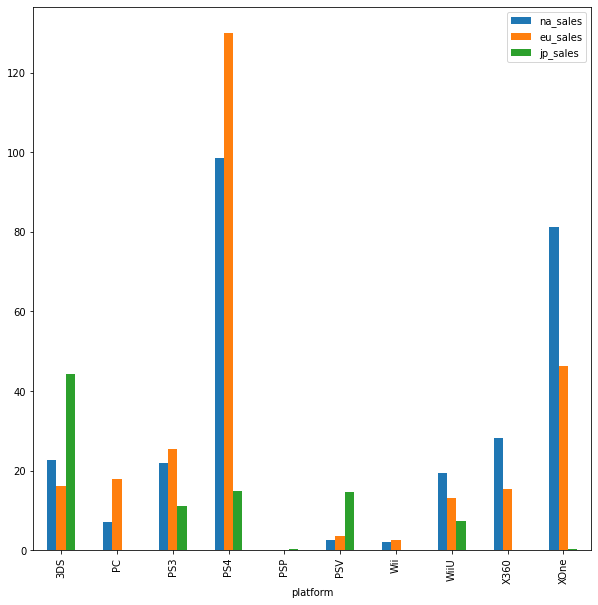

In [26]:
data_after_2013.groupby(by='platform').sum()[['na_sales','eu_sales','jp_sales']].plot.bar()

Предпочтения платформы у пользователей из разных регионов


<AxesSubplot:title={'center':'player_jp'}, ylabel='platform'>

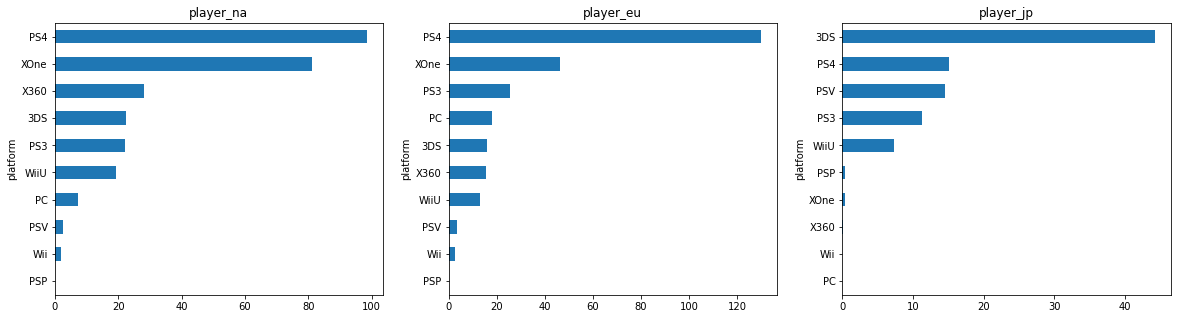

In [27]:
print("Предпочтения платформы у пользователей из разных регионов")
plt.subplot (1, 3, 1)
data_after_2013.groupby(by='platform').sum().sort_values('na_sales')['na_sales'].plot(kind='barh',title='player_na',figsize=(20,5))
plt.subplot (1, 3, 2)
data_after_2013.groupby(by='platform').sum().sort_values('eu_sales')['eu_sales'].plot(kind='barh',title='player_eu')
plt.subplot (1, 3, 3)
data_after_2013.groupby(by='platform').sum().sort_values('jp_sales')['jp_sales'].plot(kind='barh',title='player_jp')

**Вывод** <br>
Пользователи из Европы и Северной Америки предпочитают консоли PS4 и XOne, у геймеров из Японии в почете консоль 3DS. <br>
Японцы предпочитают портативность, Европейцы и Американцы - домашний гейминг.

### Самые популярные жанры в регионах

**Общая статистика**

<AxesSubplot:xlabel='genre'>

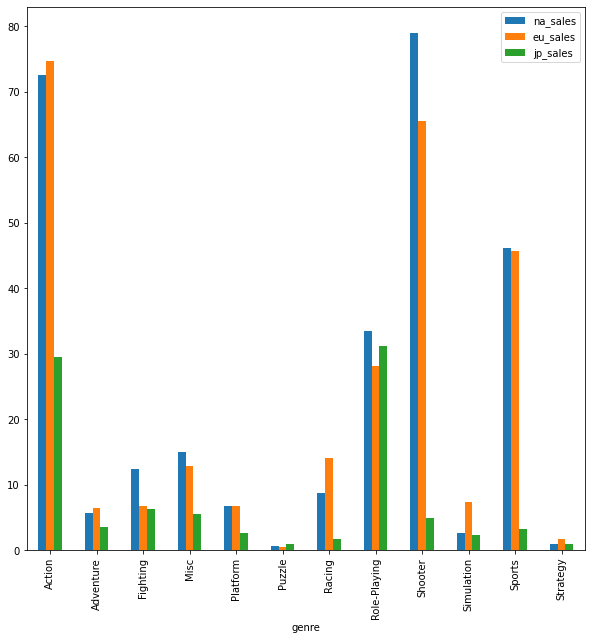

In [28]:
data_after_2013.groupby(by='genre').sum()[['na_sales','eu_sales','jp_sales']].plot.bar()

<AxesSubplot:title={'center':'player_jp'}, ylabel='genre'>

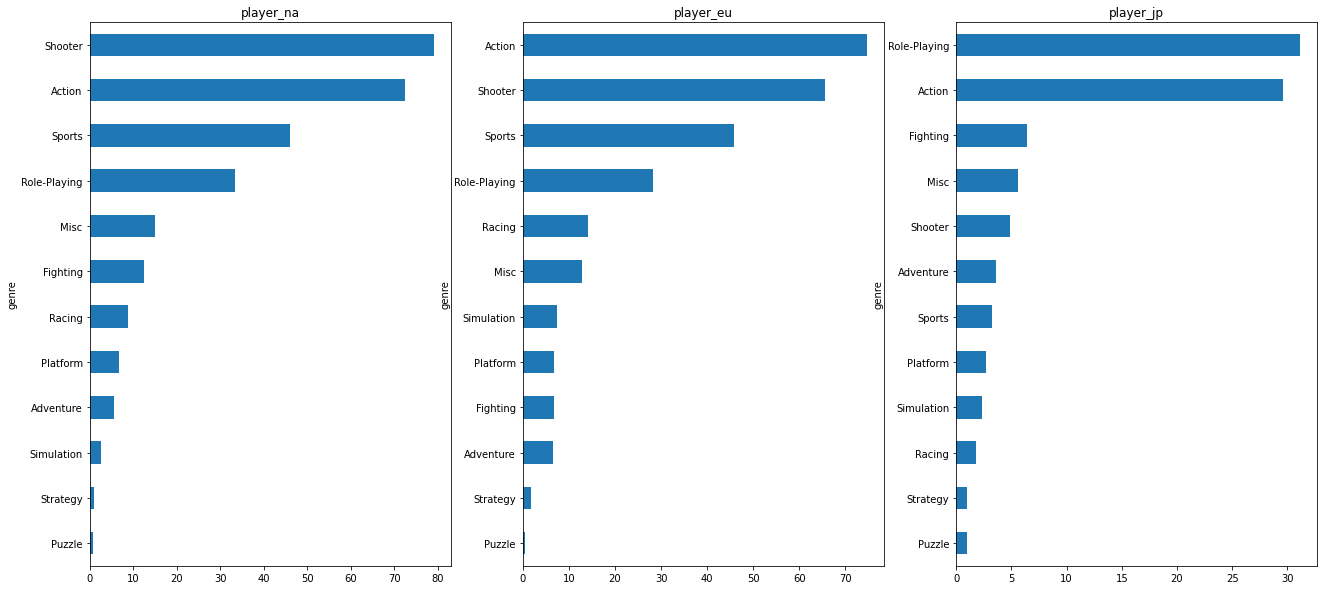

In [29]:
plt.subplot (1, 3, 1)
data_after_2013.groupby(by='genre').sum().sort_values('na_sales')['na_sales'].plot(kind='barh',title='player_na',figsize=(22,10))
plt.subplot (1, 3, 2)
data_after_2013.groupby(by='genre').sum().sort_values('eu_sales')['eu_sales'].plot(kind='barh',title='player_eu')
plt.subplot (1, 3, 3)
data_after_2013.groupby(by='genre').sum().sort_values('jp_sales')['jp_sales'].plot(kind='barh',title='player_jp')

Топы жанров по регионам


<AxesSubplot:title={'center':'JP'}, ylabel='jp_sales'>

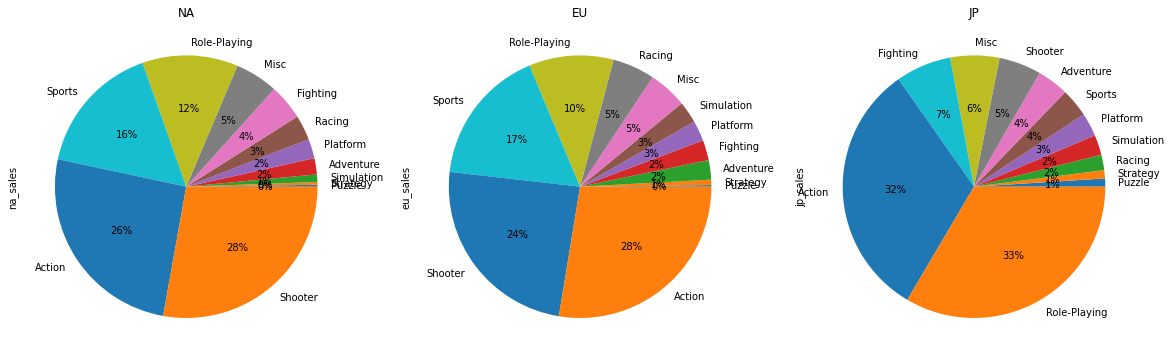

In [30]:
print("Топы жанров по регионам")
plt.subplot (1, 3, 1)
data_after_2013.groupby(by='genre').sum().sort_values('na_sales')['na_sales'].plot(kind='pie', autopct='%1.0f%%',figsize=(20,20),title='NA')
plt.subplot (1, 3, 2)
data_after_2013.groupby(by='genre').sum().sort_values('eu_sales')['eu_sales'].plot(kind='pie', autopct='%1.0f%%',figsize=(20,20),title="EU")
plt.subplot (1, 3, 3)
data_after_2013.groupby(by='genre').sum().sort_values('jp_sales')['jp_sales'].plot(kind='pie', autopct='%1.0f%%',figsize=(20,20),title="JP")

**Вывод** <br>
В EU и NA очень схожи в предпочтениях - топ 4 жанров идентичен: экшен, шутер, спорт и гонки. <br>
Пользователи из Японии же предпочитают РПГ и, с малым отрывом, экшен игры.

### Влияние ESRB рейтинг на продажи в регионах

<AxesSubplot:xlabel='rating'>

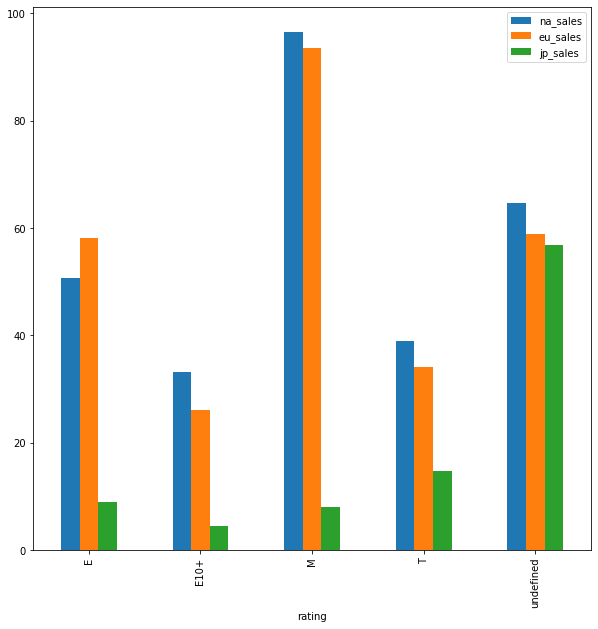

In [31]:
data_after_2013.groupby(by='rating').sum()[['na_sales','eu_sales','jp_sales']].plot.bar()

**Вывод** <br>
В Северной Америке и в Европе картина практически одинаковая. Большая часть выручки получено с игр с рейтингом - "Для всех", а далее по "взрослости" игр.

В Японии опять не так. Первое место такое же - "Не определен", скорее всего это связано с тем что сам по себе рейтнг ESRB принадлежит американской компании, следовательно не все японские игры проходят его.

In [32]:
temp = data_after_2013.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


undefined    749
T            271
M            265
E            219
E10+         185
Name: rating, dtype: int64

## Проверка гипотиз

**Гипотезы**

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. <br>

Для проверки гипотиз пользуюсь t-критерием Стьюдента - выборки независимы между собой. <br>
Пороговое значение alpha = 0.05<br>

**Гипотеза № 1** <br>
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <br>

*H0* - нулевая гипотиза - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <br>
*Н1* - альтернативная гипотиза - Средние пользовательские рейтинги платформ Xbox One и PC отличаються между собой <br>

<br>


In [33]:
s_1 = data_after_2013[data_after_2013['platform']=='XOne']['user_score'].dropna()
s_2 = data_after_2013[data_after_2013['platform']=='PC']['user_score'].dropna()

In [34]:
from scipy.stats import levene
stat, p = levene(s_1,s_2)
print(p)

0.014868430917663678


In [35]:
alpha = .05 #критический уровень статистической значимости
           #если p-value окажеться меньше него - отвергаем гипотизу

In [36]:
results_1 = st.ttest_ind(s_1,s_2,equal_var = True)
print('p-значение:',results_1.pvalue)


if (results_1.pvalue < alpha):
    print("Отвергаем нулевую гипотизу")
else: 
    print("Не получилось отвергнуть нулевую гипотизу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотизу


**Вывод**<br>

Не получилось отвергнуть нулевую гипотизу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <br>

**Гипотеза № 2** <br>
Средние пользовательские рейтинги жанров Action и Sports разные.<br>

*H0* - нулевая гипотиза - Средние пользовательские рейтинги жанров Action и Sports одинаковые.<br>
*Н1* - альтернативная гипотиза - Средние пользовательские рейтинги жанров Action и Sports разные.<br>


<br>


In [37]:
s_3 = data_after_2013[data_after_2013['genre']=='Action']['user_score'].dropna()
s_4 = data_after_2013[data_after_2013['genre']=='Sports']['user_score'].dropna()

In [38]:
from scipy.stats import levene
stat, p = levene(s_3,s_4)
print(p)

4.480161685830322e-06


In [39]:
alpha = .05 #критический уровень статистической значимости
           #если p-value окажеться меньше него - отвергаем гипотизу

In [40]:
results_2 = st.ttest_ind(s_3,s_4,equal_var = True)
print('p-значение:',results_2.pvalue)


if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотизу")
else: 
    print("Не получилось отвергнуть нулевую гипотизу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотизу


 **Вывод** <br>
Отвергаем нулевую гипотизу - исходное утверждение, что средние пользовательские рейтинги жанров Action и Sports разные - верно.

## Общий вывод

### Подготовка данных

- Была проведена процедура ознакомления с данными, были выявлены пропуски и несоотведствие формата столбцов с внутренним их содержимым.
- Были обработаны пропуски и заменены значения TBD в столбце user_score на NaN.
- Столбцы с большим обьемом пропусков - без изменений во избежании искажений данных.
- Произведен расчет значения total_sales - общих продаж по всему миру соотведствующей игры
- Были заполнены пропуски в графе rating на "не определен"

### Иследовательский анализ данных

- Рост выпуска игр начинаеться 1995 года, с периода расцвета первых консолей, пик приходиться на 2008-2010 года.
- Срок службы консоли в среднем от 7 до 10 лет, всвязи с этим для анализа была взята точка отсчета 2013 год.
- Самые потенциально прибыльные платформы PS4, Xbox One, 3DS.
- Наибольшая медиана по продажам у старого поколения консолей - PS3 и Xbox 360 (что подтверждает первый пункт, ведь именно в период 2008 по 2010 год выпускались консоли дданного поколения).
- Больше всего игр с жанром Action(экшн) и Shooter(шутер) - хоть и шутер уступает значительно жанру экшн, но один шутер в среднем приносит прибыль как 5 игр жанра экшн.

### Портрет пользователя региона

- В NA и EU предпочитают Xbox и PS в почти равной доле, в Японии же предпочитают DS.
- В Европе и Америке схожие вкусы на жанры игр - экшен, шутер, спорт и гонки, в Японии предпочитают РПГ.
- Во всех регионах игры с рейтингом E (игры без ограничений по возрасту) в топе, но все же игр с рейтингом в Японии меньше т.к рейтинг введен для США и Канады.

### Проверка гипотиз

**Не удалось отвергнуть гипотизу:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. <br>
**Удалось отвергнуть гипотизу:** Средние пользовательские рейтинги жанров Action и Sports разные,